# Predicting MLB Hall of Famers With Machine Learning

## The Problem

Every year, when the voting results are announced for the Major League Baseball Hall of Fame, no sooner do we get a chance to reflect on the careers of those awarded baseball's highest honor does someone inevitably bring up the [elephant in the room](http://bleacherreport.com/articles/2687465-breaking-down-the-2017-baseball-hall-of-fame-class-and-biggest-snubs). Each voter can only select 10 players on their ballot, which unfortunately means that someone usually gets left out. The goal here is to build a model that can accurately predict who will make it inot the HOF, and solve the debate of who the biggest snubs are once and for all. Or, something like that. 

The data I use here is taken from the [Lahman Database](http://www.seanlahman.com/baseball-archive/statistics/). At the time of this project, the database contained data from 1871 to 2015, which I narrowed down to post-World War II.

## Steps

* **Load in and tidy the data**
* **Exploratory data analysis**
* **Model selection**
* **Predict the past, present and future**

### Load the Data

In [33]:
import numpy as np
import pandas as pd

data = pd.read_csv("hofplayers.csv")
data.head()

,inducted,playerID,yearID,G,H,2B,3B,HR,RBI,BAVG,...,ASGs,name,awards,plyf_games,plyf_hits,plyf_RBI,plyf_HR,shampionships,OPS_plus,WAR
0,Y,aaronha01,1976,3298,3771,624,98,755,2297,0.305,...,17.0,Hank Aaron,16.0,17.0,25.0,16.0,6.0,1.0,152.605,142.57
1,NaN,abbotku01,2001,702,523,109,23,62,242,0.256,...,NaN,Kurt Abbott,NaN,16.0,7.0,0.0,0.0,1.0,77.677,0.57
2,NaN,adcocjo01,1966,1959,1832,295,35,336,1122,0.277,...,2.0,Joe Adcock,NaN,9.0,7.0,2.0,0.0,1.0,124.394,33.47
3,N,ageeto01,1973,1129,999,170,27,130,433,0.255,...,NaN,Tommie Agee,3.0,8.0,8.0,5.0,3.0,1.0,77.942,25.35
4,NaN,aldremi01,1996,930,565,104,9,41,271,0.263,...,NaN,Mike Aldrete,NaN,8.0,1.0,1.0,0.0,1.0,82.160,8.87


In [34]:
data.columns

Index(['inducted', 'playerID', 'yearID', 'G', 'H', '2B', '3B', 'HR', 'RBI',
       'BAVG', 'SLG', 'OBP', 'OPS', 'POS', 'ASGs', 'name', 'awards',
       'plyf_games', 'plyf_hits', 'plyf_RBI', 'plyf_HR', 'shampionships',
       'OPS_plus', 'WAR'],
      dtype='object')

For the most part, the variables I've chosen are your standard water-cooler baseball stats, with the exception of two "advanced metrics": wins above replacement and OPS plus. These I thought might be fun to throw in there, since until recently they were largely ignored or unheard of, so any correlation they have with historical voting would have been completely unbeknownst to the voters. We also have the number of all-star games each player was invited to, the total number of awards they received throughout their career (including MVPs, Silver Slugger, Golden Glove, etc.), fielding position and all of their total postseason totals, including World Series titles ([no, it's not a typo](https://www.youtube.com/watch?v=NJx-1EOeUDs)). So all of the averages like BAVG (batting average), and SLG (slugging percentage) are averages over the player's career, and the rest are lifetime totals.

The only changes I'll make to this set of features for the analysis is removing the non-numeric ones. I've decided that factorizing each player's fielding position into 9 variables may not be worth the extra model complexity, and "inducted" (the target variable), "yearID" and "name" shouldn't be included for obvious reasons.

A note about the year ID: this is the last year the player was in the league. I have this so that I can break out which players are eligible to be voted on (retired prior to 2011), which will be all of our labeled data that we'll use to build a model, since these players have all either been voted on or never will be (with the exception of a few, like Barry Bonds, who have already been on the ballot and will remain there for a few more years to come). The rest of the observations are players who have either retired recently and are eligible to be on the ballot in coming years, or are still in the league. These are the ones we'll want to try to predict later on.

The following code separates the two groups, fills N/A values and converts the target variable into a boolean. Also, I'll get the list of column names and take out the non-numeric ones. 

In [35]:
import warnings; warnings.simplefilter('ignore')
data = data.set_index('playerID')
current = data[data['yearID'] > 2011]
eligible = data[data['yearID'] <= 2011]
eligible.loc[:,'inducted'] = eligible.loc[:,'inducted'].fillna('N')
label_dict = {'Y': True, 'N': False}
eligible.loc[:,'inducted'] = eligible.loc[:,'inducted'].map(label_dict)
eligible = eligible.fillna(0)

cols = list(data)
cols = [col for col in cols if col not in ('inducted','yearID','POS','name')]
cols1 = cols[:10]
cols2 = cols[10:]

### Exploring the Data

I'll start with boxplots of all the variables, showing the interquartile range of each statistic for Hall of Fame vs all other players

Populating the interactive namespace from numpy and matplotlib


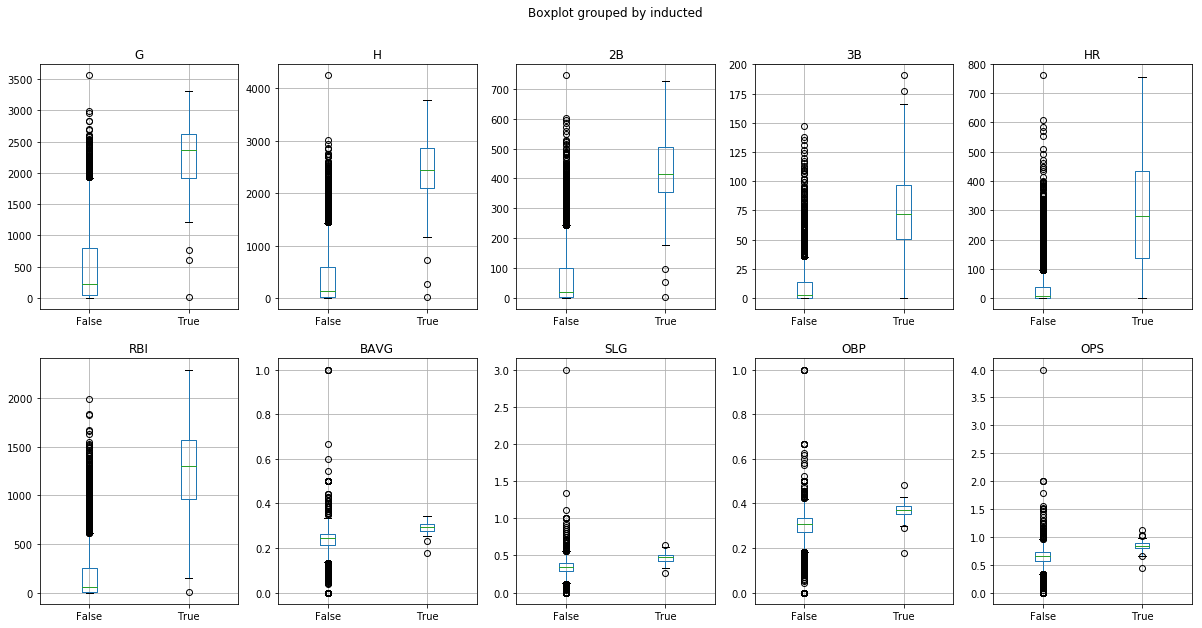

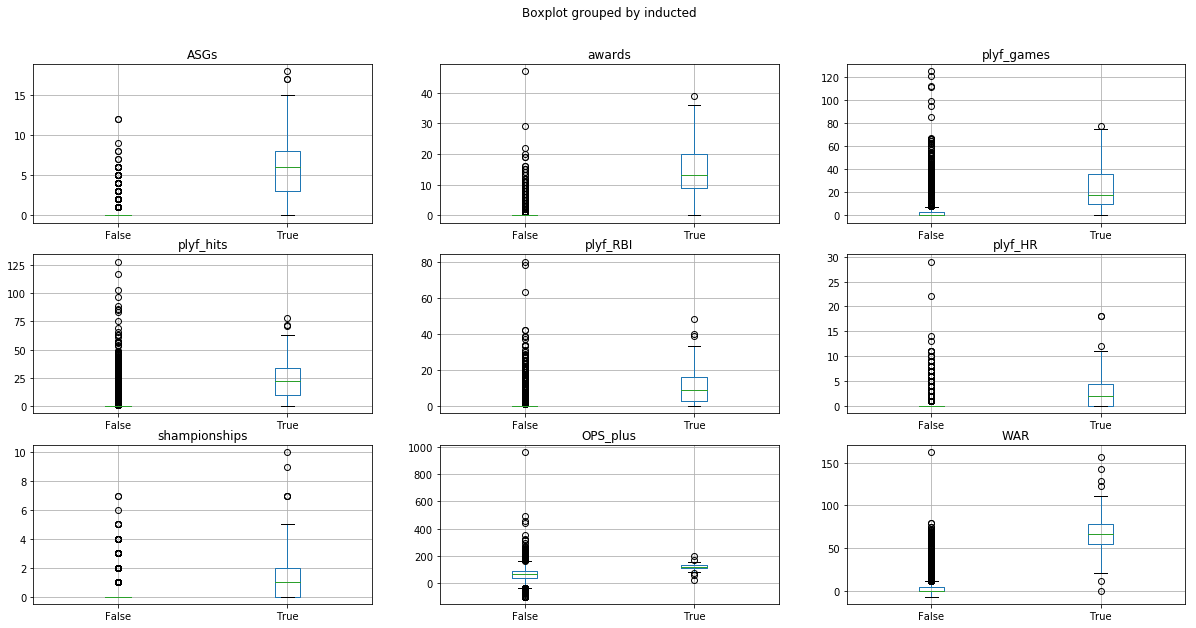

In [4]:
import matplotlib.pyplot as plt
from pandas import scatter_matrix
%pylab inline
pylab.rcParams['figure.figsize'] = (20,10)

fig, axes = plt.subplots(2,5)
for i, ax in enumerate(axes.reshape(-1)):
    eligible.boxplot(cols1[i], 'inducted', ax = ax)
    ax.set_xlabel('')
    
fig, axes = plt.subplots(3,3)
for i, ax in enumerate(axes.reshape(-1)):
    eligible.boxplot(cols2[i], 'inducted', ax = ax)
    ax.set_xlabel('')

At first glance, we can tell one thing for sure: the difference between hall of famers and the rest is no joke, and appears to be most prevalent among the basic career totals like games and hits (and sure enough, WAR). 

The second takeaway here is that there seem to be some oddballs in the data. A career OPS of 4, for example, seems pretty out of place. In many of the averaged variables (Batting, Slugging, OPS_plus), there are several outliers in the non-inducted group that reach way above those in the inducted group. This could require further investigation. 

In [5]:
data[data['OPS']>1].sort_values('OPS', ascending=False).head(15)

,inducted,yearID,G,H,2B,3B,HR,RBI,BAVG,SLG,...,ASGs,name,awards,plyf_games,plyf_hits,plyf_RBI,plyf_HR,shampionships,OPS_plus,WAR
playerID,,,,,,,,,,,,,,,,,,,,,
lindsch02,NaN,1958,1,1,0,1,0,1,1.000,3.000,...,NaN,Charlie Lindstrom,NaN,NaN,NaN,NaN,NaN,NaN,961.527,0.14
bandyje01,NaN,2015,2,1,0,0,1,1,0.500,2.000,...,NaN,Jett Bandy,NaN,NaN,NaN,NaN,NaN,NaN,256.668,1.51
liddeda01,NaN,1990,1,1,0,0,0,0,1.000,1.000,...,NaN,Dave Liddell,NaN,NaN,NaN,NaN,NaN,NaN,454.004,0.08
tupmama01,NaN,2008,1,1,0,0,0,0,1.000,1.000,...,NaN,Matt Tupman,NaN,NaN,NaN,NaN,NaN,NaN,440.108,0.05
paciojo01,NaN,1963,1,3,0,0,0,3,1.000,1.000,...,NaN,John Paciorek,NaN,NaN,NaN,NaN,NaN,NaN,495.189,0.22
riverca02,NaN,2014,4,4,2,0,1,3,0.571,1.286,...,NaN,Carlos Rivero,NaN,NaN,NaN,NaN,NaN,NaN,417.329,0.01
mcdonke01,NaN,2001,8,3,0,0,3,5,0.333,1.333,...,NaN,Keith McDonald,NaN,NaN,NaN,NaN,NaN,NaN,169.997,0.22
brettry01,NaN,2015,3,2,1,0,0,0,0.667,1.000,...,NaN,Ryan Brett,NaN,NaN,NaN,NaN,NaN,NaN,385.933,0.10
jimerch01,NaN,2008,31,4,0,0,2,2,0.444,1.111,...,NaN,Charlton Jimerson,NaN,NaN,NaN,NaN,NaN,NaN,221.727,0.29


So, we have a problem. Players with less than 100-200 games played have no place in my box plot, or any part of this analysis for that matter.

Selecting only players with more than 200 games, and redoing the rest of the tidying:

In [6]:
data2 = data[data['G']>200]
current2 = data2[data2['yearID'] > 2011]
eligible2 = data2[data2['yearID'] <= 2011]
eligible2.loc[:,'inducted'] = eligible2.loc[:,'inducted'].fillna('N')
label_dict = {'Y': True, 'N': False}
eligible2.loc[:,'inducted'] = eligible2.loc[:,'inducted'].map(label_dict)
eligible2 = eligible2.fillna(0)
eligible2[(eligible2['HR']<100)&(eligible2['inducted']==True)]

,inducted,yearID,G,H,2B,3B,HR,RBI,BAVG,SLG,...,ASGs,name,awards,plyf_games,plyf_hits,plyf_RBI,plyf_HR,shampionships,OPS_plus,WAR
playerID,,,,,,,,,,,,,,,,,,,,,
aparilu01,True,1973,2601,2677,394,92,83,791,0.262,0.343,...,8.0,Luis Aparicio,15.0,10.0,12.0,2.0,0.0,1.0,81.759,55.72
boudrlo01,True,1952,1646,1779,385,66,68,789,0.295,0.415,...,3.0,Lou Boudreau,11.0,6.0,6.0,3.0,0.0,1.0,96.621,62.97
ashburi01,True,1962,2189,2574,317,109,29,586,0.308,0.382,...,2.0,Richie Ashburn,0.0,4.0,3.0,1.0,0.0,0.0,110.423,63.59
carewro01,True,1985,2469,3053,445,112,92,1015,0.328,0.429,...,15.0,Rod Carew,14.0,14.0,11.0,1.0,0.0,0.0,129.681,81.06
applilu01,True,1950,2422,2749,440,102,45,1116,0.310,0.398,...,2.0,Luke Appling,10.0,0.0,0.0,0.0,0.0,0.0,110.752,74.45
foxne01,True,1965,2367,2663,355,112,35,790,0.288,0.363,...,8.0,Nellie Fox,9.0,6.0,9.0,0.0,0.0,0.0,80.037,48.96
ferreri01,True,1947,1884,1692,324,45,28,734,0.281,0.363,...,2.0,Rick Ferrell,0.0,0.0,0.0,0.0,0.0,0.0,93.694,29.84
irvinmo01,True,1956,764,731,97,31,99,443,0.293,0.475,...,0.0,Monte Irvin,0.0,10.0,13.0,4.0,0.0,1.0,115.826,21.30
hermabi01,True,1947,1922,2345,486,82,47,839,0.304,0.407,...,6.0,Billy Herman,9.0,18.0,16.0,7.0,1.0,0.0,107.067,54.74


Now let's try these boxplots again.

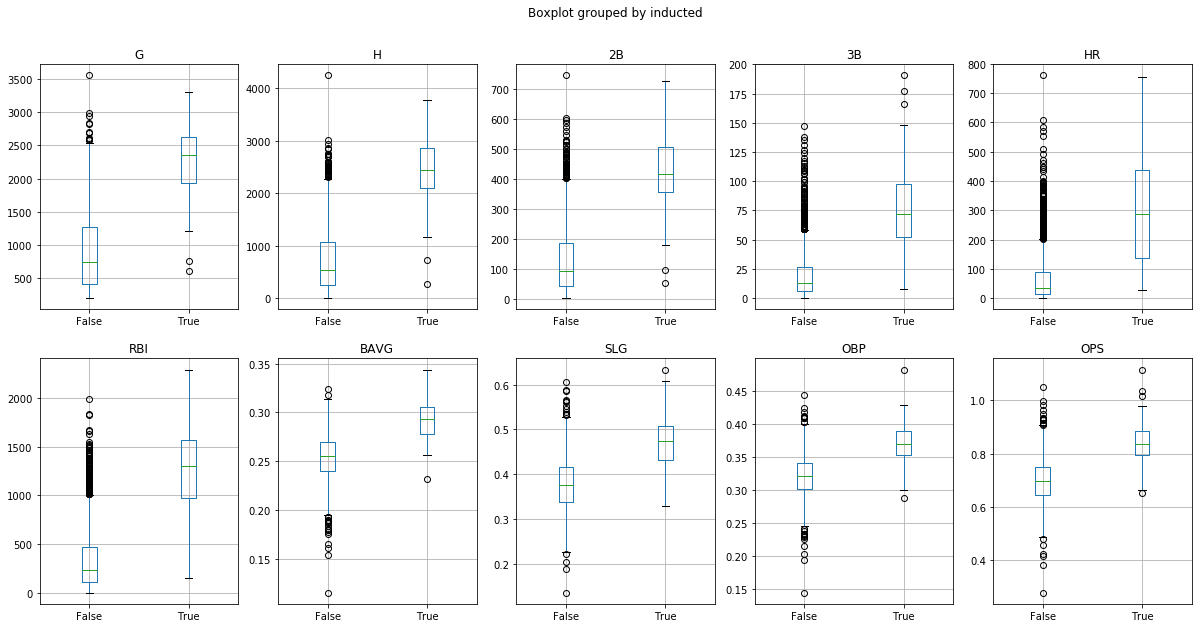

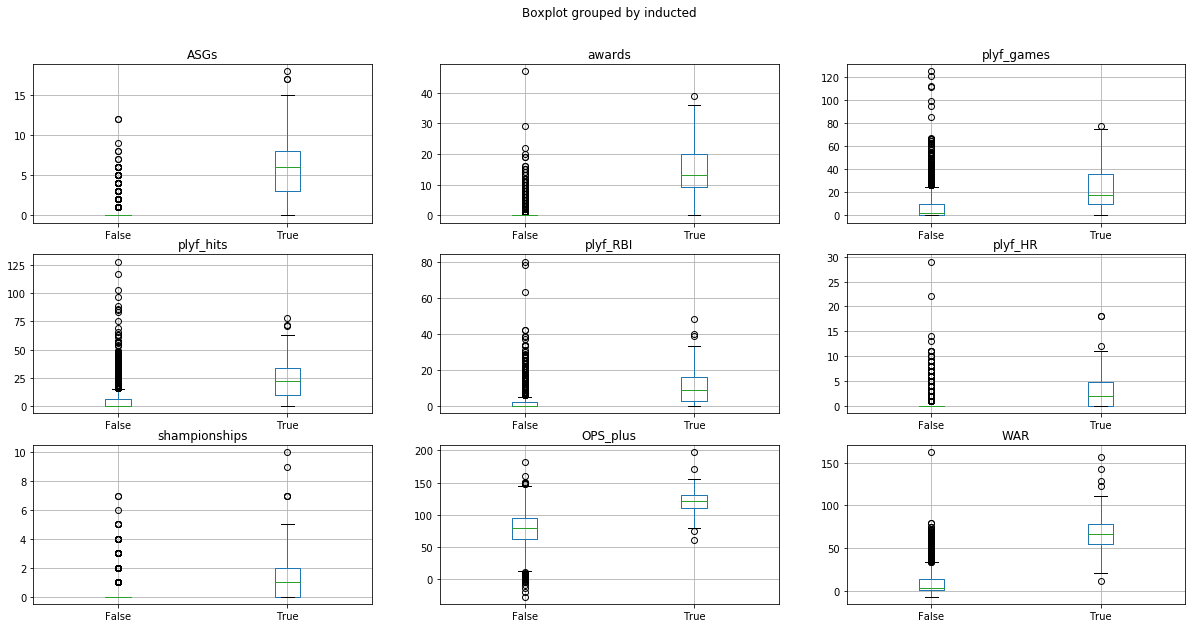

In [7]:
fig, axes = plt.subplots(2,5)
for i, ax in enumerate(axes.reshape(-1)):
    eligible2.boxplot(cols1[i], 'inducted', ax = ax)
    ax.set_xlabel('')
    
fig, axes = plt.subplots(3,3)
for i, ax in enumerate(axes.reshape(-1)):
    eligible2.boxplot(cols2[i], 'inducted', ax = ax)
    ax.set_xlabel('')

Ah, much better. The separation between groups in particular variables is now even more visible. In fact we can say for sure now that, in almost every one of these categories, the 25th percentile of HOFers doesn't even cross the 75th percentile of all others. 

Now perhaps you're wondering why it still looks like there are a few outliers in the players who weren't inducted (hint: there are).

100

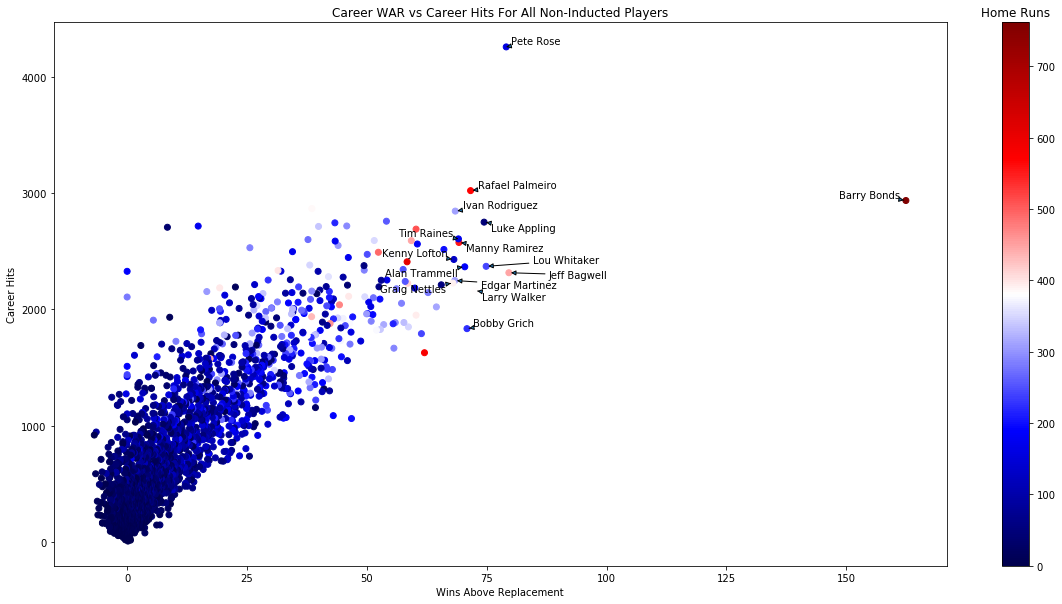

In [8]:
from adjustText import adjust_text

rejects = eligible2[eligible2['inducted']==False]
rejects = rejects.sort_values('WAR', ascending = False)
rejects_names = rejects['name'].head(15)

texts=[]
plt.scatter('WAR', 'H', data = rejects, c='HR',cmap=plt.cm.seismic)
plt.xlabel("Wins Above Replacement")
plt.ylabel("Career Hits")
plt.title("Career WAR vs Career Hits For All Non-Inducted Players")
cb = plt.colorbar(orientation='vertical')
cb.ax.set_title("Home Runs",)
for x, y, name in zip(rejects.loc[:,'WAR'], rejects.loc[:,'H'], rejects_names):
    texts.append(plt.text(x,y,name))
adjust_text(texts, force_text=0.01, arrowprops = dict(arrowstyle = '-|>'))

Definitely some outliers here. But I digress.

Next, let's look at a scatter matrix to see how our variables interact with one another, and just for fun we'll also group by inducted again. Don't squint too hard to see the legend - the HOFers are in blue.

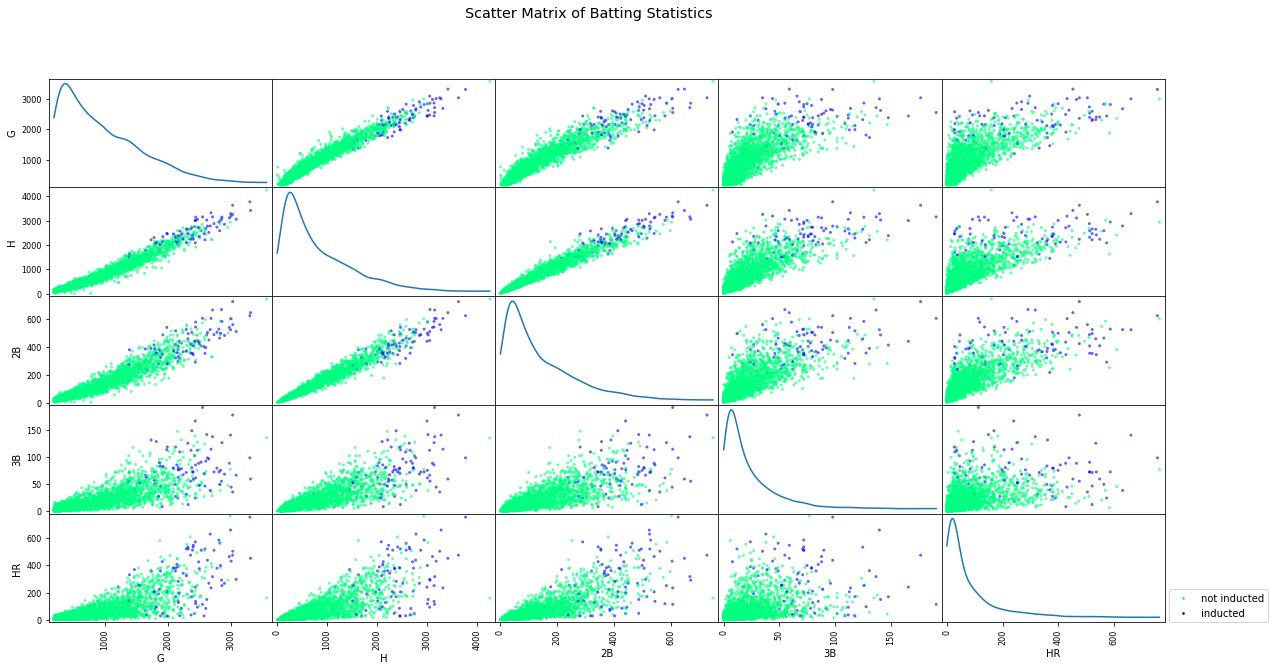

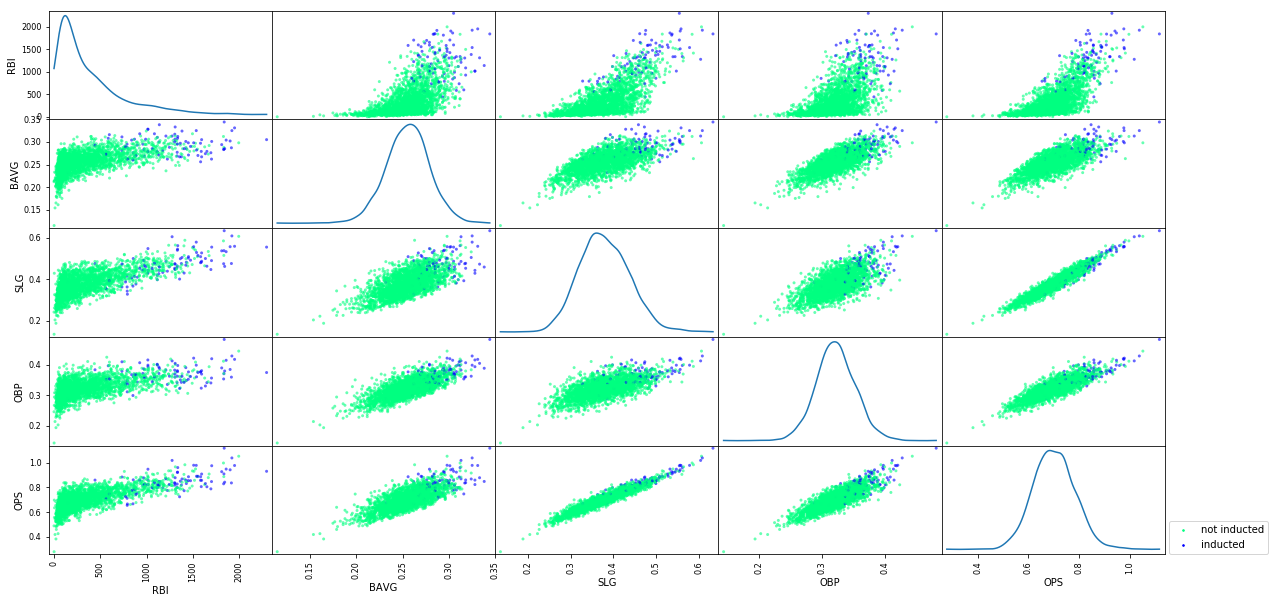

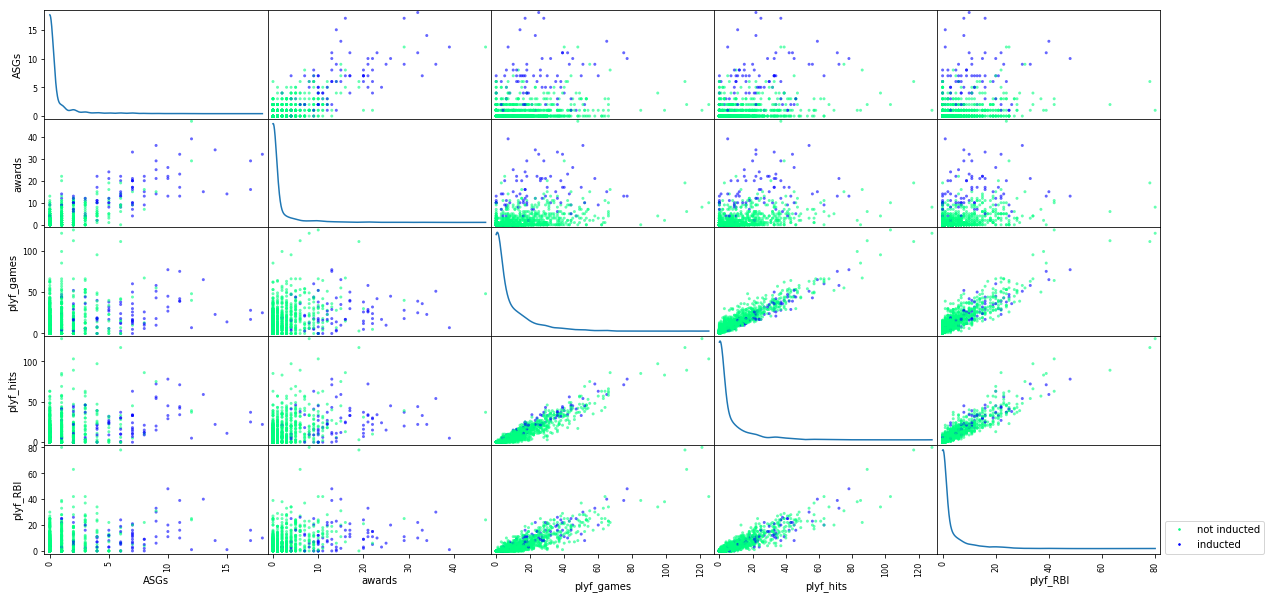

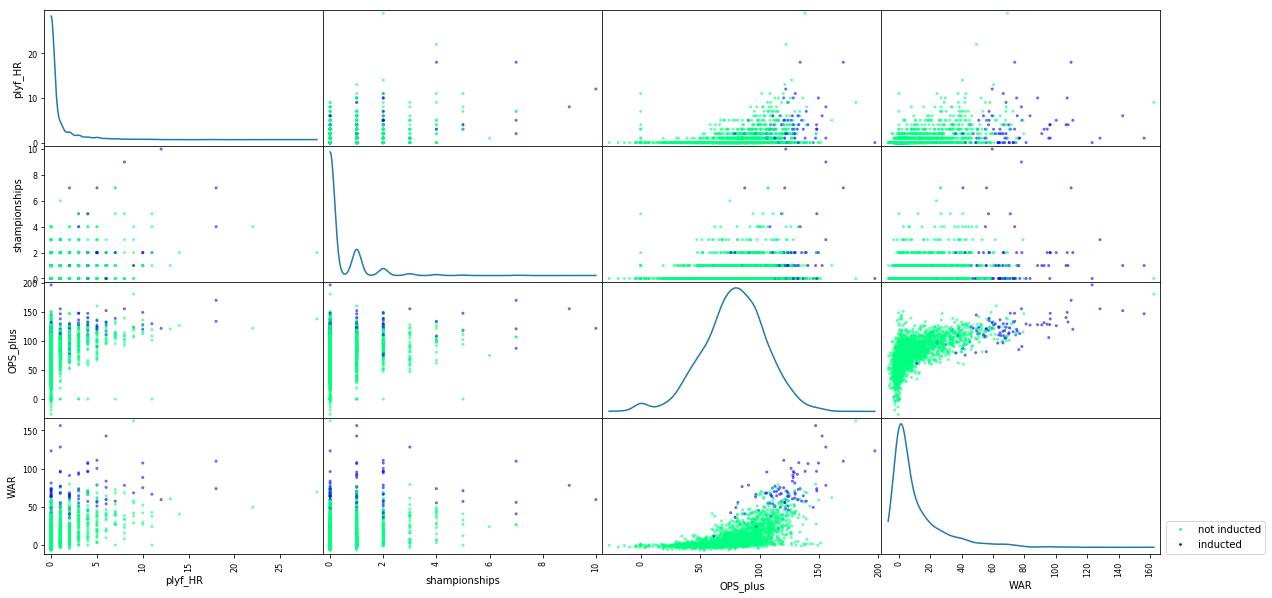

In [9]:
scatter_matrix(eligible2[cols1[:5]], figsize = (20,10), diagonal = 'kde', c = eligible2['inducted'], 
               cmap=plt.cm.winter_r, alpha = 0.6)
handles = [plt.plot([],[],color=plt.cm.winter_r(i/1.), ls="", marker=".",
                    markersize=np.sqrt(10))[0] for i in range(3)]
labels=["not inducted", "inducted"]

plt.legend(handles, labels, loc=(1.02,0))
plt.suptitle("Scatter Matrix of Batting Statistics", fontsize = 'x-large')
plt.show()

scatter_matrix(eligible2[cols1[5:]], figsize = (20,10), diagonal = 'kde', c = eligible2['inducted'], 
               cmap=plt.cm.winter_r, alpha = 0.6)
plt.legend(handles, labels, loc=(1.02,0))
plt.show()

scatter_matrix(eligible2[cols2[:5]], figsize = (20,10), diagonal = 'kde', c = eligible2['inducted'], 
               cmap=plt.cm.winter_r,alpha = 0.6)
plt.legend(handles, labels, loc=(1.02,0))
plt.show()

scatter_matrix(eligible2[cols2[5:]], figsize = (20,10), diagonal = 'kde', c = eligible2['inducted'], 
               cmap=plt.cm.winter_r, alpha = 0.6)
plt.legend(handles, labels, loc=(1.02,0))
plt.show()

So, there are too many features to plot them all against each other but we get the idea: most of them are very co-dependent. Luckily our modeling algorithms will do most of the work selecting important features and dealing with colinearity. What's interesting here though is how distinct the groups are in the "WAR" vs "OPS_plus" feature space. Again, for the vast majority of the players in this dataset, these things weren't taken into consideration when they were voted on, so we get a sense of how good of an indicator something like WAR is of overall success. Neat!

Finally let's check out the frequency distributions of each variable, once again broken down by group.

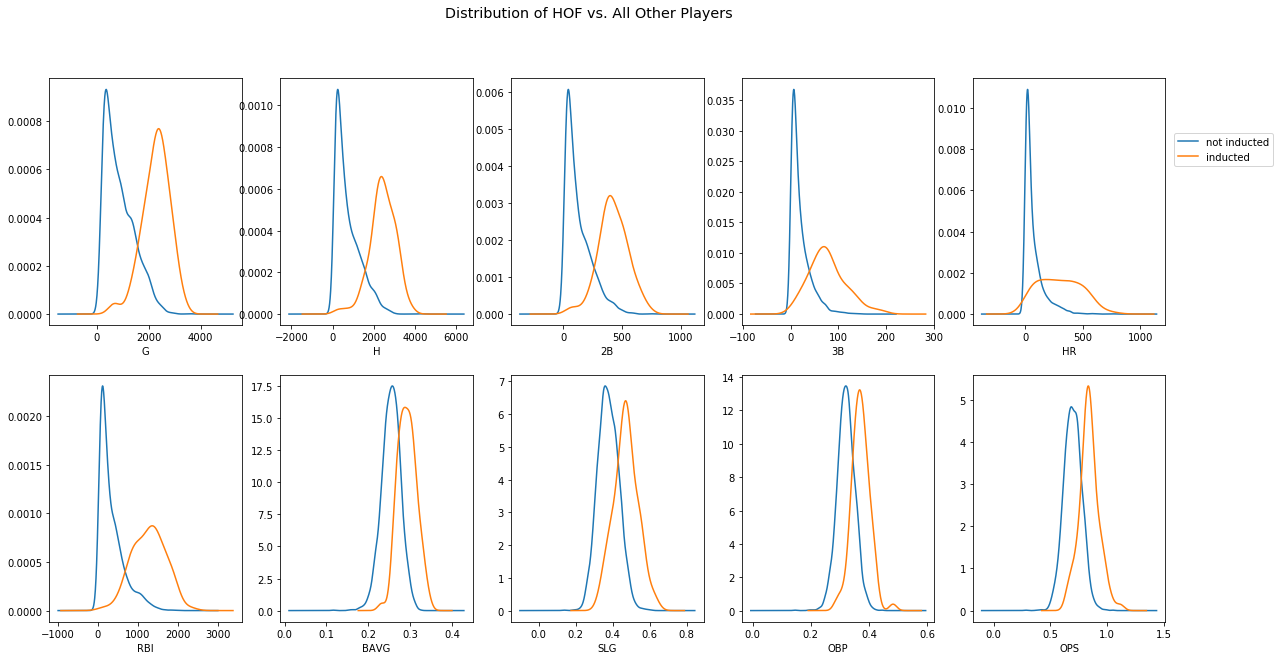

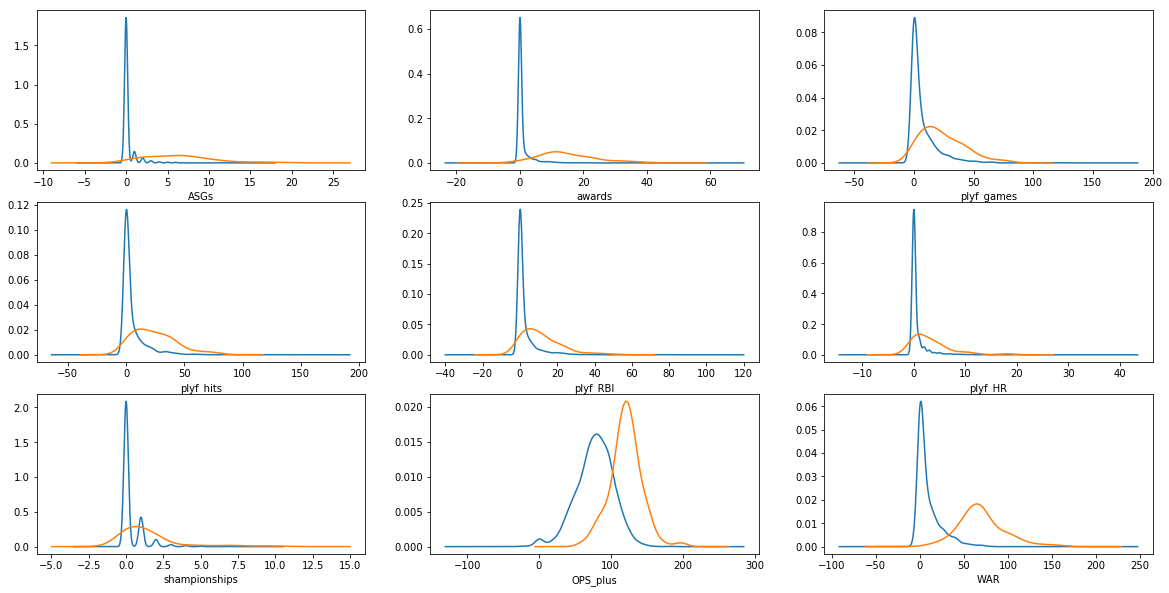

In [10]:
fig, axes = plt.subplots(2,5)
fig.suptitle('Distribution of HOF vs. All Other Players', fontsize='x-large')
for i, ax in enumerate(axes.reshape(-1)):
    col = cols1[i]
    eligible2.groupby('inducted')[col].plot(kind = 'kde', ax = ax)
    ax.set_xlabel(col)
    ax.set_ylabel('')
plt.legend(['not inducted', 'inducted'], bbox_to_anchor=(1.02,2), loc=2)

fig, axes = plt.subplots(3,3)
for i, ax in enumerate(axes.reshape(-1)):
    col = cols2[i]
    eligible2.groupby('inducted')[col].plot(kind = 'kde', ax = ax)
    ax.set_xlabel(col)
    ax.set_ylabel('')

Mostly more of the same here. While there is overlap in some of the categories, higher values are significantly more frequent for HOFers.

# Fitting the Model


To start, we'll need a test set and a training set, which I'll split up from the labeled data.

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics  
from sklearn.grid_search import GridSearchCV   
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import graphviz

target = eligible2['inducted']
features = eligible2[cols]
feat_names = features.columns

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,
                                                    random_state=64, stratify=target)

Now, we know that many more players don't make it into the Hall than do, so I'll use an oversampling algorithm that synthesizes data from the minority class based on K-nearest neighbors so the model can put some more weight into observations from this class.

In [12]:
smote = SMOTE(random_state=10, ratio=1.0)
x_train_bal, y_train_bal = smote.fit_sample(X_train, y_train)

Now that our data is set to go, I'll create a quick function to see the accuracy metrics of each model we're testing, as well as a confusion matrix to show the predicted versus actual values in each group. From there I'll go straight into the model selection.

In [13]:
def model_eval(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    model_preds = model.predict(X_test)
    model_probs = model.predict_proba(X_test)[:,1]
    cv_score = cross_val_score(model, features, target, cv=5, scoring='roc_auc')
    print(model_name, "Model Evaluation:\n")
    print("\tTest Set Accuracy: %f" % metrics.accuracy_score(y_test.values, model_preds))
    print("\tTraining AUC Score: %f" % metrics.roc_auc_score(y_test.values, model_probs))
    print("\tTraining Cross Validation Score: Mean: %.4g, StdDev: %.4g, Min: %.4g, Max: %.4g\n"
          % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

    print("Confusion Matrix:\n")
    print(confusion_matrix(y_test, model_preds))
    print("\nClassification Report:\n")
    print(classification_report(y_test, model_preds))

### K Nearest Neighbors Model

In [14]:
knn = KNeighborsClassifier(n_neighbors=5)

model_eval(knn, "K-Nearest Neighbors Classifier", x_train_bal, y_train_bal, X_test, y_test)

    # try scaling the features

steps = [('scaler', StandardScaler()),
         ('knn', KNeighborsClassifier(n_neighbors=5))]

pipe = Pipeline(steps)

model_eval(pipe, "KNN W/Normalized Features", x_train_bal, y_train_bal, X_test, y_test)

K-Nearest Neighbors Classifier Model Evaluation:

	Test Set Accuracy: 0.914563
	Training AUC Score: 0.900426
	Training Cross Validation Score: Mean: 0.8854, StdDev: 0.05948, Min: 0.8107, Max: 0.9908

Confusion Matrix:

[[458  41]
 [  3  13]]

Classification Report:

             precision    recall  f1-score   support

      False       0.99      0.92      0.95       499
       True       0.24      0.81      0.37        16

avg / total       0.97      0.91      0.94       515

KNN W/Normalized Features Model Evaluation:

	Test Set Accuracy: 0.951456
	Training AUC Score: 0.952718
	Training Cross Validation Score: Mean: 0.9085, StdDev: 0.03016, Min: 0.8677, Max: 0.9614

Confusion Matrix:

[[476  23]
 [  2  14]]

Classification Report:

             precision    recall  f1-score   support

      False       1.00      0.95      0.97       499
       True       0.38      0.88      0.53        16

avg / total       0.98      0.95      0.96       515



Right off the bat, we predicted the test set with 95.7% accuracy, and 97.9% after scaling the features. This is all well and good, but what I'm mostly concerned with is how well I can identify actual Hall of Famers, or the true positive rate. What the tables in this output are showing me are,

Confusion Matrix:

|condition false|condition true|
---|---|---
prediction false|true negatives|false positives
prediction true|false negatives (want to be low)| true positives (want to be high)

Classification Report:

|precision|recall|f1-score|support|
---|---|---|---|---
false (non-inducted group)|true negatives/(true negatives + true positives)|true negatives/(true negatives + false positives)|harmonic mean of precision and recall|# of observations in group
true (inducted group)|true positives/(true positives + true negatives)|true positives/(true positives + false negatives)|harmonic mean of precision and recall|# of observations in group

So I'm most interested in seeing a low rate of false negatives and high recall score for the indcuted group, and I personally am OK with the model giving me some false positives, especially since we know by now that some of those guys were definitely snubbed anyway. 

With that out of the way let's compare some other models.

### Decision Tree Classifier

In [15]:
tree = DecisionTreeClassifier()

model_eval(tree, "Basic Decision Tree", x_train_bal, y_train_bal, X_test, y_test)

Basic Decision Tree Model Evaluation:

	Test Set Accuracy: 0.955340
	Training AUC Score: 0.795466
	Training Cross Validation Score: Mean: 0.7547, StdDev: 0.04667, Min: 0.7029, Max: 0.8307

Confusion Matrix:

[[482  17]
 [  6  10]]

Classification Report:

             precision    recall  f1-score   support

      False       0.99      0.97      0.98       499
       True       0.37      0.62      0.47        16

avg / total       0.97      0.96      0.96       515



### Random Forest

In [16]:
rf = RandomForestClassifier()

model_eval(rf, "Random Forest Decision Tree", x_train_bal, y_train_bal, X_test, y_test)

Random Forest Decision Tree Model Evaluation:

	Test Set Accuracy: 0.968932
	Training AUC Score: 0.885709
	Training Cross Validation Score: Mean: 0.9596, StdDev: 0.0273, Min: 0.9282, Max: 0.993

Confusion Matrix:

[[491   8]
 [  8   8]]

Classification Report:

             precision    recall  f1-score   support

      False       0.98      0.98      0.98       499
       True       0.50      0.50      0.50        16

avg / total       0.97      0.97      0.97       515



### Logistic Regression

In [17]:
OVR = OneVsRestClassifier(LogisticRegression())

model_eval(OVR, "One vs. Rest CV Logistic Regression", x_train_bal, y_train_bal, X_test, y_test)

One vs. Rest CV Logistic Regression Model Evaluation:

	Test Set Accuracy: 0.963107
	Training AUC Score: 0.982214
	Training Cross Validation Score: Mean: 0.9786, StdDev: 0.01223, Min: 0.9642, Max: 0.993

Confusion Matrix:

[[481  18]
 [  1  15]]

Classification Report:

             precision    recall  f1-score   support

      False       1.00      0.96      0.98       499
       True       0.45      0.94      0.61        16

avg / total       0.98      0.96      0.97       515



### Gradient Boosting Classifier

In [18]:
gradboost = GradientBoostingClassifier(random_state = 10)

model_eval(gradboost, "Gradient Boosting Classifier", x_train_bal, y_train_bal, X_test, y_test)

Gradient Boosting Classifier Model Evaluation:

	Test Set Accuracy: 0.968932
	Training AUC Score: 0.927605
	Training Cross Validation Score: Mean: 0.975, StdDev: 0.01629, Min: 0.9548, Max: 0.9952

Confusion Matrix:

[[489  10]
 [  6  10]]

Classification Report:

             precision    recall  f1-score   support

      False       0.99      0.98      0.98       499
       True       0.50      0.62      0.56        16

avg / total       0.97      0.97      0.97       515



For this model, there are a lot of hyperparameters that must be tuned to find the best fit, so I'll try making this one a little better, credit to [this tutorial](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/) for the methodology. I won't go into the details of how each parameter was chosen at each stage of grid search cross-validation, but the final tuned model is as follows: 

In [19]:
tuned_gb = GradientBoostingClassifier(learning_rate=0.01, n_estimators = 1000,
                                      max_features = 4, random_state = 10, subsample = 0.85,
                                      min_samples_split = 2, max_depth = 4, min_samples_leaf=80)

model_eval(tuned_gb, "Tuned Gradient Boosting", x_train_bal, y_train_bal, X_test, y_test)

Tuned Gradient Boosting Model Evaluation:

	Test Set Accuracy: 0.976699
	Training AUC Score: 0.982214
	Training Cross Validation Score: Mean: 0.9862, StdDev: 0.005419, Min: 0.9792, Max: 0.9938

Confusion Matrix:

[[490   9]
 [  3  13]]

Classification Report:

             precision    recall  f1-score   support

      False       0.99      0.98      0.99       499
       True       0.59      0.81      0.68        16

avg / total       0.98      0.98      0.98       515



That's a little better, but the logistic regression model still has this beat.

### XGBoost 

In [20]:
xgb1 = XGBClassifier(learning_rate=0.05, n_estimators=2000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8,
                     colsample_bytree=0.8, objective='binary:logistic', nthread=4, scale_pos_weight=10, seed=27)

xgb_params = xgb1.get_xgb_params()
xgb_train = xgb.DMatrix(X_train, y_train)
xgb_cv = xgb.cv(xgb_params, xgb_train, num_boost_round=xgb1.get_xgb_params()['n_estimators'], nfold=5, metrics='auc',
                early_stopping_rounds=50)
xgb1.set_params(n_estimators=xgb_cv.shape[0])

model_eval(xgb1, "Extreme Gradient Boosting Classifier", X_train, y_train, X_test, y_test)

Extreme Gradient Boosting Classifier Model Evaluation:

	Test Set Accuracy: 0.978641
	Training AUC Score: 0.978707
	Training Cross Validation Score: Mean: 0.9858, StdDev: 0.005571, Min: 0.9795, Max: 0.995

Confusion Matrix:

[[492   7]
 [  4  12]]

Classification Report:

             precision    recall  f1-score   support

      False       0.99      0.99      0.99       499
       True       0.63      0.75      0.69        16

avg / total       0.98      0.98      0.98       515



After tuning again,

In [21]:
xgb2 = XGBClassifier(learning_rate=0.01, n_estimators = 3000, max_depth=3,min_child_weight=10, gamma=0.4, subsample=0.9,
                     colsample_bytree=0.55, objective='binary:logistic', nthrea=4, scale_pos_weight=10,seed=27, reg_alpha=0)

xgb2_params = xgb2.get_xgb_params()
xgb2_train = xgb.DMatrix(X_train, y_train)
xgb2_cv = xgb.cv(xgb2_params, xgb2_train, num_boost_round=xgb2.get_xgb_params()['n_estimators'], nfold=5, metrics='auc',
                early_stopping_rounds=50)
xgb2.set_params(n_estimators=xgb2_cv.shape[0])

model_eval(xgb2, "Final XGBoost", X_train, y_train, X_test, y_test)

Final XGBoost Model Evaluation:

	Test Set Accuracy: 0.972816
	Training AUC Score: 0.985095
	Training Cross Validation Score: Mean: 0.987, StdDev: 0.004958, Min: 0.9783, Max: 0.9918

Confusion Matrix:

[[487  12]
 [  2  14]]

Classification Report:

             precision    recall  f1-score   support

      False       1.00      0.98      0.99       499
       True       0.54      0.88      0.67        16

avg / total       0.98      0.97      0.98       515



In terms of the true recall rate, this is a close second to logistic regression. The scaled KNN model also gave us the same number of true positives, but the overall prediction accuracy on the test set was much worse.

Summarizing all of this with the ROC cruve,

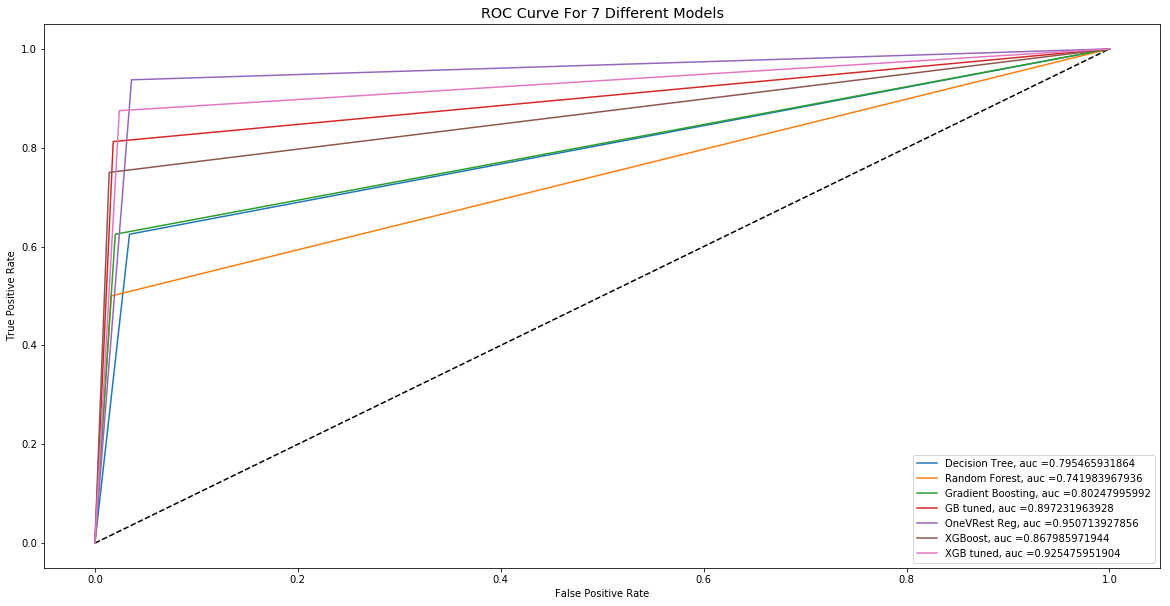

In [22]:
fpr, tpr, tresh = metrics.roc_curve(y_test, tree.predict(X_test))
auc = metrics.roc_auc_score(y_test, tree.predict(X_test))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label = "Decision Tree, auc ="+str(auc))

fpr, tpr, tresh = metrics.roc_curve(y_test, rf.predict(X_test))
auc = metrics.roc_auc_score(y_test, rf.predict(X_test))
plt.plot(fpr, tpr, label = "Random Forest, auc ="+str(auc))

fpr, tpr, tresh = metrics.roc_curve(y_test, gradboost.predict(X_test))
auc = metrics.roc_auc_score(y_test, gradboost.predict(X_test))
plt.plot(fpr, tpr, label = "Gradient Boosting, auc ="+str(auc))

fpr, tpr, tresh = metrics.roc_curve(y_test, tuned_gb.predict(X_test))
auc = metrics.roc_auc_score(y_test, tuned_gb.predict(X_test))
plt.plot(fpr, tpr, label = "GB tuned, auc ="+str(auc))

fpr, tpr, tresh = metrics.roc_curve(y_test, OVR.predict(X_test))
auc = metrics.roc_auc_score(y_test, OVR.predict(X_test))
plt.plot(fpr, tpr, label = "OneVRest Reg, auc ="+str(auc))

fpr, tpr, tresh = metrics.roc_curve(y_test, xgb1.predict(X_test))
auc = metrics.roc_auc_score(y_test, xgb1.predict(X_test))
plt.plot(fpr, tpr, label = "XGBoost, auc ="+str(auc))

fpr, tpr, tresh = metrics.roc_curve(y_test, xgb2.predict(X_test))
auc = metrics.roc_auc_score(y_test, xgb2.predict(X_test))
plt.plot(fpr, tpr, label = "XGB tuned, auc ="+str(auc))

plt.title("ROC Curve For 7 Different Models", fontsize="x-large")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)

Here we can see the true positive rate graphed against the false positive rate as the classification threshold goes up (default is a sample with 50% probability is labeled true, and as this threshold increases the true positive rate will naturally decrease, and vise versa). Logistic regression seems to beat everything else out in this metric as well. I'll start with this model when I try to make my predictions. Which just so happens to be right now.

## Predicting the future.

First I'll take our list of current players from before, select the proper features and start prophesizing.

In [23]:
X_current = current2[cols]
X_current = X_current.fillna(0)
X_current = X_current.sort_values("WAR", ascending = False)
current2 = current2.sort_values("WAR", ascending = False)

OVR.fit(X_train, y_train) # fit the model again, this time globally
current_preds = OVR.predict(X_current)
current_probs = OVR.predict_proba(X_current)

Now, adding the predicted probabilities into the original dataset and sorting all players in descending order, we get a leaderboard for active players.

In [24]:
current2.loc[:,"HOF%"] = current_probs[:,1]
current2 = current2.sort_values("HOF%", ascending=False)
current2[current2['HOF%']>.5]

,inducted,yearID,G,H,2B,3B,HR,RBI,BAVG,SLG,...,name,awards,plyf_games,plyf_hits,plyf_RBI,plyf_HR,shampionships,OPS_plus,WAR,HOF%
playerID,,,,,,,,,,,,,,,,,,,,,
rodrial01,NaN,2015,2719,3070,541,31,687,2055,0.297,0.554,...,Alex Rodriguez,31.0,76.0,72.0,41.0,13.0,1.0,128.191,117.71,0.997792
jeterde01,NaN,2014,2747,3465,544,66,260,1311,0.310,0.440,...,Derek Jeter,20.0,158.0,200.0,61.0,20.0,5.0,109.846,71.83,0.996447
pujolal01,NaN,2015,2274,2666,583,16,560,1698,0.312,0.581,...,Albert Pujols,23.0,77.0,90.0,54.0,19.0,2.0,151.184,100.95,0.932996
suzukic01,NaN,2015,2357,2935,341,91,113,738,0.314,0.406,...,Ichiro Suzuki,19.0,19.0,27.0,8.0,1.0,NaN,100.303,59.42,0.840632
beltrad01,NaN,2015,2567,2767,560,35,413,1467,0.285,0.477,...,Adrian Beltre,8.0,25.0,27.0,11.0,5.0,NaN,113.858,90.21,0.814511
beltrca01,NaN,2015,2306,2454,503,78,392,1443,0.280,0.490,...,Carlos Beltran,8.0,52.0,61.0,40.0,16.0,NaN,119.818,70.03,0.506905


Okay then, problem solved. Only 6 current players are ever going to the hall of fame. Guess we're done here. 

No, wait. We can do better than that. Looks like we'll have to use some *gasp* common sense in our model selection. Let's check out the results for the runner-up model model: the tuned extreme gradient boosting.

In [25]:
X_current = current2[cols]
X_current = X_current.fillna(0)
X_current = X_current.sort_values("WAR", ascending = False)
current2 = current2.sort_values("WAR", ascending = False)

xgb2.fit(X_train, y_train) 
current_preds = xgb2.predict(X_current)
current_probs = xgb2.predict_proba(X_current)

current2.loc[:,"HOF%"] = current_probs[:,1]
current2 = current2.sort_values("HOF%", ascending=False)
current2[current2['HOF%']>.5]

,inducted,yearID,G,H,2B,3B,HR,RBI,BAVG,SLG,...,name,awards,plyf_games,plyf_hits,plyf_RBI,plyf_HR,shampionships,OPS_plus,WAR,HOF%
playerID,,,,,,,,,,,,,,,,,,,,,
jeterde01,NaN,2014,2747,3465,544,66,260,1311,0.310,0.440,...,Derek Jeter,20.0,158.0,200.0,61.0,20.0,5.0,109.846,71.83,0.591982
rodrial01,NaN,2015,2719,3070,541,31,687,2055,0.297,0.554,...,Alex Rodriguez,31.0,76.0,72.0,41.0,13.0,1.0,128.191,117.71,0.589225
pujolal01,NaN,2015,2274,2666,583,16,560,1698,0.312,0.581,...,Albert Pujols,23.0,77.0,90.0,54.0,19.0,2.0,151.184,100.95,0.589225
suzukic01,NaN,2015,2357,2935,341,91,113,738,0.314,0.406,...,Ichiro Suzuki,19.0,19.0,27.0,8.0,1.0,NaN,100.303,59.42,0.587421
beltrca01,NaN,2015,2306,2454,503,78,392,1443,0.280,0.490,...,Carlos Beltran,8.0,52.0,61.0,40.0,16.0,NaN,119.818,70.03,0.587036
rolensc01,NaN,2012,2038,2077,517,43,316,1287,0.281,0.490,...,Scott Rolen,13.0,39.0,31.0,12.0,5.0,1.0,116.365,69.99,0.586036
ortizda01,NaN,2015,2257,2303,584,18,503,1641,0.284,0.547,...,David Ortiz,14.0,82.0,87.0,60.0,17.0,3.0,128.766,55.43,0.582092
heltoto01,NaN,2013,2247,2519,592,37,369,1406,0.316,0.539,...,Todd Helton,12.0,15.0,12.0,4.0,0.0,NaN,125.976,61.16,0.579503
cabremi01,NaN,2015,1938,2331,492,16,408,1445,0.321,0.562,...,Miguel Cabrera,14.0,55.0,57.0,38.0,13.0,1.0,150.898,69.61,0.578007


Now that's more like it. While this doesn't look perfect (intuitively, I'm not sure it makes sense for Carlos Beltran to be predicted higher than the likes of Adrian Beltre or David Ortiz), in general, most of the players we'd expect to see on this list, are. Let's take a deeper look into how this model makes its decisions.

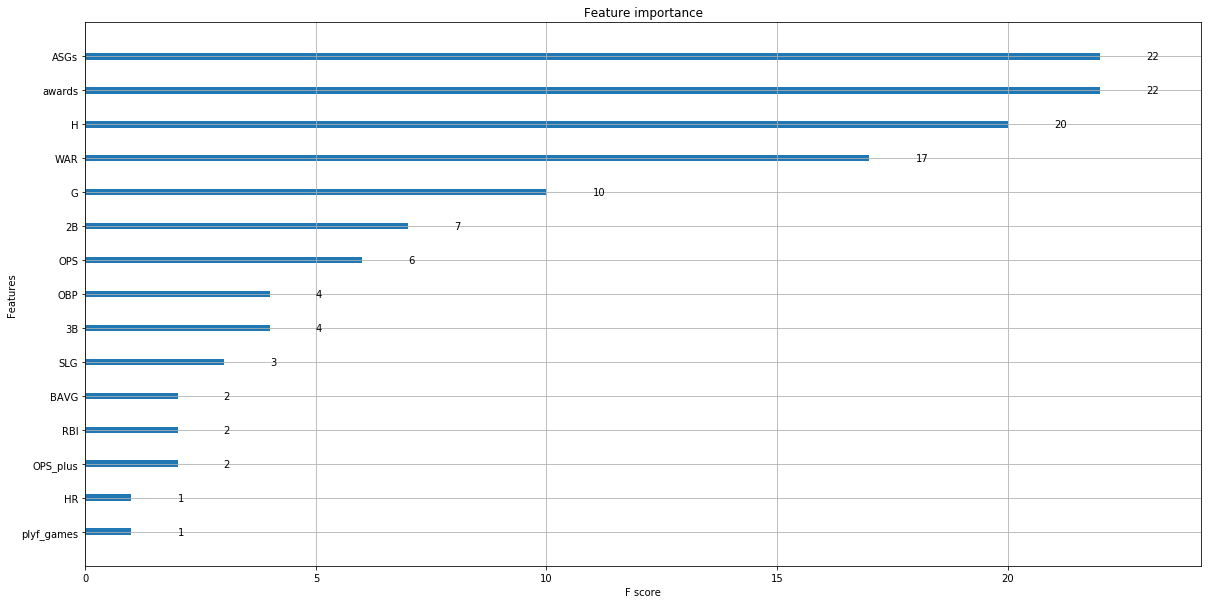

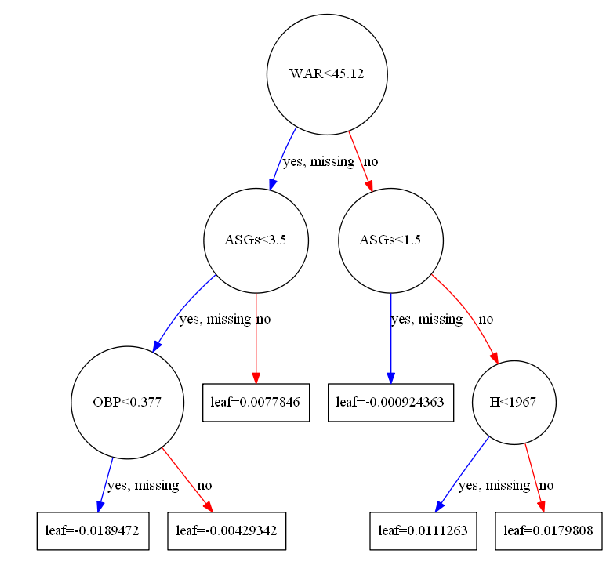

In [26]:
plot_importance(xgb2)
xgb.plot_tree(xgb2, num_trees=3)

Now, this here all makes a whole lot of sense. The features that added the most to this model are awards, all-star games, total hits and wins above replacement. The first two are no-brainers, since those are also based on a voting system. Total hits says a lot about a players' ability and longevity, as does career WAR. 

The second plot shows us the kind of cutoffs the model used to classify players. For example, if a player has greater than 45 wins above replacement, more than 1 all star game and more than 1,967 hits, they get a relatively high prediction score. Alternatively, if the player has more than 45 WAR but one or fewer all star games, the score is actually negative. This is nice, because it's very similar to how we mortal beings make our judgements about players as well. 

Since we know that WAR and hits are very important features for this model, I'll go ahead and visualize the predicted probability along with these stats. Keep in mind that the probabilities don't necessarily correspond to the player's exact chance of being inducted - the rank order of probabilities is what's more important here.

16

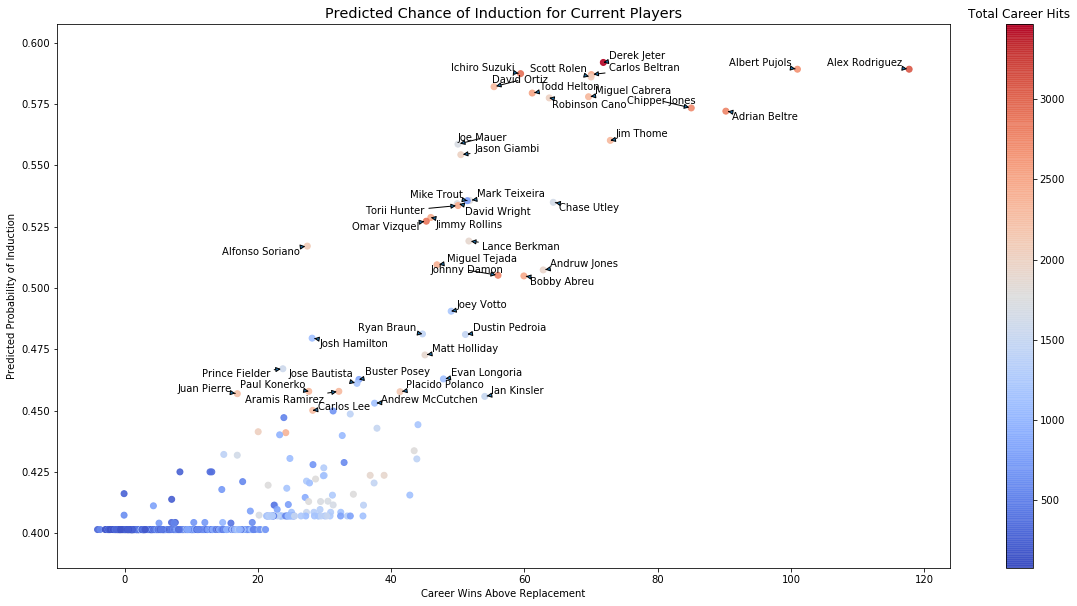

In [27]:
names_current = current2[current2['HOF%']>0.45]['name'].values
texts = []
plt.scatter("WAR", "HOF%", data=current2, c=current2['H'], cmap=plt.cm.coolwarm,alpha=0.9)
plt.title("Predicted Chance of Induction for Current Players", fontsize = 'x-large')
plt.xlabel("Career Wins Above Replacement")
plt.ylabel("Predicted Probability of Induction")
cb = plt.colorbar(orientation='vertical')
cb.ax.set_title("Total Career Hits")
for x, y, lab in zip(current2.loc[:,'WAR'], current2.loc[:,'HOF%'], names_current):
    texts.append(plt.text(x, y, lab))
adjust_text(texts, force_text=0.01, arrowprops = dict(arrowstyle = '-|>'))

Again, some of these can be taken with a grain of salt. However it seems like, generally speaking, the relative placement of a lot of these players seems pretty accruate. We can sort of see a few clusters here, with A-Rod, Jeter, Pujols, Ichiro and the like in the top tier, then below about 55% we find Jimmy Rollins, Miguel Tejada and Omar Vizquel types, and between 50% and 45% a lot of players who eventually we'd expect to see in the higher groups, but who still have a lot of work to do before their careers are done. My favorite part of this graph is where we find Mike Trout: 24 years old and already creeping up on Jason Giambi in a model that puts huge stock into longevity. I guesss he's alright. 

Let's now see how the model stacks up against very recently labeled data. We'll try to predict this year's class, who were just voted on in March. 

In [28]:
class_2017_IDs = pd.read_csv("2017_class.csv")
class_2017_IDs = class_2017_IDs['playerID'].values
class_2017 = data.ix[class_2017_IDs]
class_2017_stats = data.ix[class_2017_IDs, cols]
class_2017_stats = class_2017_stats.fillna(0)

class_2017_preds = xgb2.predict(class_2017_stats)
class_2017_probs = xgb2.predict_proba(class_2017_stats)

class_2017["HOF%"] = class_2017_probs[:,1]
class_2017 = class_2017.sort_values("HOF%", ascending=False)
class_2017

,inducted,yearID,G,H,2B,3B,HR,RBI,BAVG,SLG,...,name,awards,plyf_games,plyf_hits,plyf_RBI,plyf_HR,shampionships,OPS_plus,WAR,HOF%
playerID,,,,,,,,,,,,,,,,,,,,,
bondsba01,N,2007.0,2986.0,2935.0,601.0,77.0,762.0,1996.0,0.298,0.607,...,Barry Bonds,47.0,48.0,37.0,24.0,9.0,NaN,181.023,162.43,0.591982
rodriiv01,NaN,2011.0,2543.0,2844.0,572.0,51.0,311.0,1332.0,0.296,0.464,...,Ivan Rodriguez,29.0,40.0,39.0,25.0,4.0,1.0,100.561,68.44,0.591982
guerrvl01,NaN,2011.0,2147.0,2590.0,477.0,46.0,449.0,1496.0,0.318,0.553,...,Vladimir Guerrero,15.0,44.0,45.0,20.0,2.0,NaN,131.543,59.27,0.590537
ramirma02,NaN,2011.0,2302.0,2574.0,547.0,20.0,555.0,1831.0,0.312,0.585,...,Manny Ramirez,19.0,111.0,117.0,78.0,29.0,2.0,138.249,69.20,0.589225
walkela01,N,2005.0,1988.0,2160.0,471.0,62.0,383.0,1311.0,0.313,0.565,...,Larry Walker,14.0,28.0,23.0,15.0,7.0,NaN,133.798,72.60,0.588800
sosasa01,N,2007.0,2354.0,2408.0,379.0,45.0,609.0,1667.0,0.273,0.534,...,Sammy Sosa,16.0,15.0,13.0,7.0,2.0,NaN,119.386,58.39,0.588121
martied01,N,2004.0,2055.0,2247.0,514.0,15.0,309.0,1261.0,0.312,0.515,...,Edgar Martinez,10.0,34.0,34.0,24.0,8.0,NaN,139.549,68.34,0.586558
kentje01,N,2008.0,2298.0,2461.0,560.0,47.0,377.0,1518.0,0.290,0.500,...,Jeff Kent,8.0,49.0,47.0,23.0,9.0,NaN,118.571,55.16,0.579624
mcgrifr01,N,2004.0,2460.0,2490.0,441.0,24.0,493.0,1550.0,0.284,0.509,...,Fred McGriff,7.0,50.0,57.0,37.0,10.0,1.0,126.064,52.40,0.574674


34

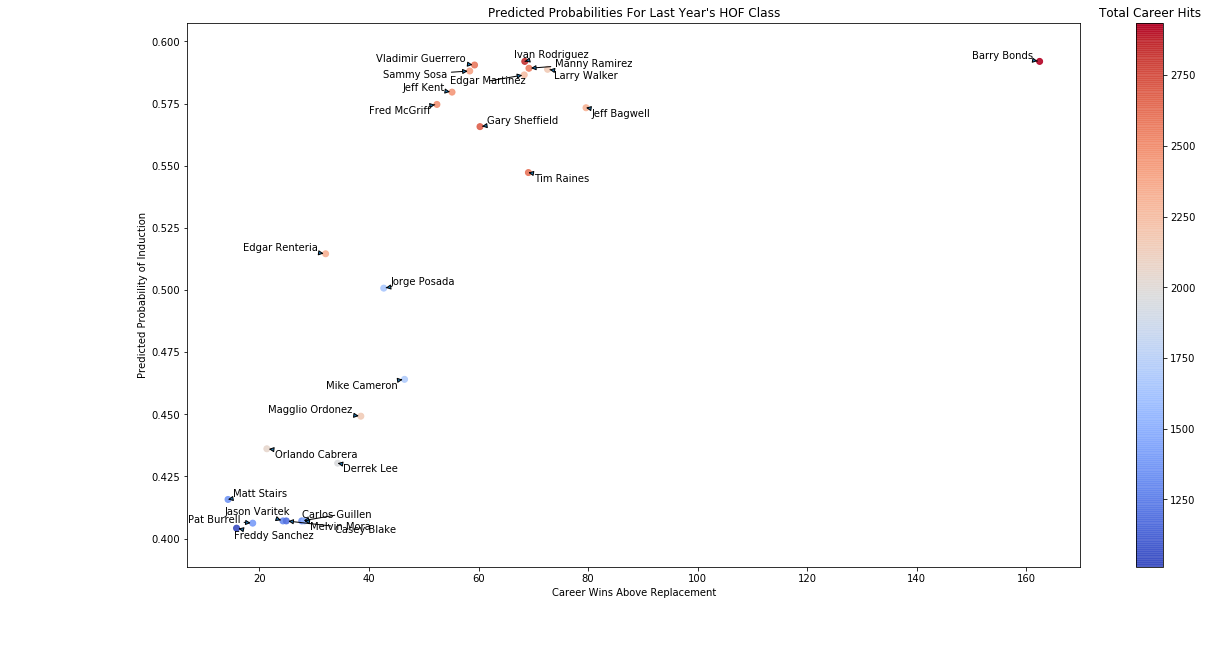

In [29]:
plt.clf()
class_2017_names = class_2017['name']
texts=[]
plt.figure(figsize=(20,10))
plt.scatter("WAR", "HOF%", data=class_2017, c=class_2017['H'], cmap=plt.cm.coolwarm,alpha=0.9)
plt.title("Predicted Probabilities For Last Year's HOF Class")
plt.xlabel("Career Wins Above Replacement")
plt.ylabel("Predicted Probability of Induction")
cb = plt.colorbar(orientation='vertical')
cb.ax.set_title("Total Career Hits",)
for x, y, name in zip(class_2017.loc[:,'WAR'], class_2017.loc[:,'HOF%'], class_2017_names):
    texts.append(plt.text(x,y,name))
adjust_text(texts, force_text=0.01, arrowprops = dict(arrowstyle = '-|>'))

In this data we see some very distinct groups. If we compare this to the [actual voting results](https://www.baseball-reference.com/awards/hof_2017.shtml), we find something very interesting indeed. All of the players who didn't receive enough votes to advance to next year's ballot (10%) are in the bottom left group, and the rest are up above in the top cluster. This is true even for someone like Magglio Ordonez, who according to Baseball Reference's hall of fame monitor, is supposed to get in but got 0.7% of votes. Then again, Renteria is floating around somewhere in the middle despite also getting less than 1% of votes. But who's counting. Overall I'm fairly happy with the results, and for the most part, my model would agree with Zach Rymer on who the biggest snubs were (author of the [article](http://bleacherreport.com/articles/2687465-breaking-down-the-2017-baseball-hall-of-fame-class-and-biggest-snubs) linked way up at the top). 

Let's try the same exercise for next year's expected class.

In [30]:
class_2018_IDs = pd.read_csv("2018_class.csv")
class_2018_IDs = class_2018_IDs['playerID'].values
class_2018 = data.ix[class_2018_IDs]
class_2018_stats = data.ix[class_2018_IDs, cols]
class_2018_stats = class_2018_stats.fillna(0)

class_2019_preds = xgb2.predict(class_2018_stats)
class_2018_probs = xgb2.predict_proba(class_2018_stats)

class_2018["HOF%"] = class_2018_probs[:,1]
class_2018 = class_2018.sort_values("HOF%", ascending=False)
class_2018

,inducted,yearID,G,H,2B,3B,HR,RBI,BAVG,SLG,...,name,awards,plyf_games,plyf_hits,plyf_RBI,plyf_HR,shampionships,OPS_plus,WAR,HOF%
playerID,,,,,,,,,,,,,,,,,,,,,
bondsba01,N,2007,2986,2935,601,77,762,1996,0.298,0.607,...,Barry Bonds,47.0,48.0,37.0,24.0,9.0,NaN,181.023,162.43,0.591982
guerrvl01,NaN,2011,2147,2590,477,46,449,1496,0.318,0.553,...,Vladimir Guerrero,15.0,44.0,45.0,20.0,2.0,NaN,131.543,59.27,0.590537
ramirma02,NaN,2011,2302,2574,547,20,555,1831,0.312,0.585,...,Manny Ramirez,19.0,111.0,117.0,78.0,29.0,2.0,138.249,69.20,0.589225
walkela01,N,2005,1988,2160,471,62,383,1311,0.313,0.565,...,Larry Walker,14.0,28.0,23.0,15.0,7.0,NaN,133.798,72.60,0.588800
sosasa01,N,2007,2354,2408,379,45,609,1667,0.273,0.534,...,Sammy Sosa,16.0,15.0,13.0,7.0,2.0,NaN,119.386,58.39,0.588121
martied01,N,2004,2055,2247,514,15,309,1261,0.312,0.515,...,Edgar Martinez,10.0,34.0,34.0,24.0,8.0,NaN,139.549,68.34,0.586558
rolensc01,NaN,2012,2038,2077,517,43,316,1287,0.281,0.490,...,Scott Rolen,13.0,39.0,31.0,12.0,5.0,1.0,116.365,69.99,0.586036
kentje01,N,2008,2298,2461,560,47,377,1518,0.290,0.500,...,Jeff Kent,8.0,49.0,47.0,23.0,9.0,NaN,118.571,55.16,0.579624
mcgrifr01,N,2004,2460,2490,441,24,493,1550,0.284,0.509,...,Fred McGriff,7.0,50.0,57.0,37.0,10.0,1.0,126.064,52.40,0.574674


21

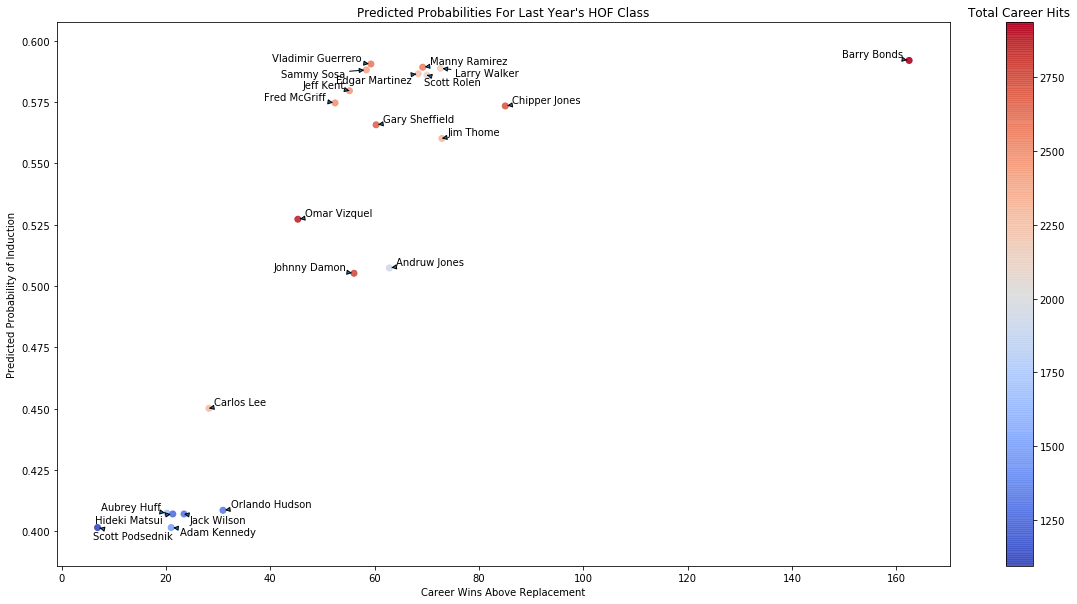

In [31]:
plt.clf()
class_2018_names = class_2018['name']
texts=[]
plt.figure(figsize=(20,10))
plt.scatter("WAR", "HOF%", data=class_2018, c=class_2018['H'], cmap=plt.cm.coolwarm,alpha=0.9)
plt.title("Predicted Probabilities For Last Year's HOF Class")
plt.xlabel("Career Wins Above Replacement")
plt.ylabel("Predicted Probability of Induction")
cb = plt.colorbar(orientation='vertical')
cb.ax.set_title("Total Career Hits",)
for x, y, name in zip(class_2018.loc[:,'WAR'], class_2018.loc[:,'HOF%'], class_2018_names):
    texts.append(plt.text(x,y,name))
adjust_text(texts, force_text=0.01, arrowprops = dict(arrowstyle = '-|>'))

Mostly the same list, but watch out for Scott Rolen and Jim Thome next year! Well, maybe not since players are rarely inducted in their first year on the ballot, but...someday. 

### Next Steps

- Use only advanced stats or sabermetrics in the model
- Use only averages or career projects to see how well younger players would be expected to stack up when it's all said and  done
- Try out different algorithms
- Extrapolate to predict All-Star selections each year